In [1]:
suppressMessages(suppressWarnings(library(VennDiagram)))
suppressMessages(suppressWarnings(library(vcd)))
suppressMessages(suppressWarnings(library(plyr)))
suppressMessages(suppressWarnings(library(ggplot2)))
suppressMessages(suppressWarnings(library(ggbeeswarm)))
suppressMessages(suppressWarnings(library(vcdExtra)))
suppressMessages(suppressWarnings(library(dplyr)))
source("../lib/pcaFunctions.R")

### The following block of code preforms RNA seq analysis from the raw HTseq reads. The first 89 samples (columns) are African; the remaining 373 are European. Ethnicities were taken the from metadata of the 1000 Genomes Project. Note that this takes up to 10 minutes.

In [2]:
suppressMessages(suppressWarnings(library(DESeq2)))
count.table <- read.table("../data/S5_Dataset.txt")
grp <- c(rep("AFR",89),rep("EUR",373))
cData <- data.frame(ethnicity = as.factor(grp))
rownames(cData) <- colnames(count.table)
d.deseq <- DESeqDataSetFromMatrix(countData = count.table,colData = cData, design = ~ethnicity)
d.deseq <- DESeq(d.deseq)
res <- results(d.deseq,contrast=c("ethnicity","EUR","AFR"))
res$ensembl_id <- rownames(res)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 1032 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



### This code saves the significant genes from the DEseq2 result and adds a few columns of annotations: abs(fold change); EBML (yes/no); and eSTR (yes/no).

In [3]:
overlap <- read.table("../data/S1_Dataset.txt",header = TRUE)
EBML <- data.frame(overlap[which(overlap$EBML=="YES" & overlap$tissueSig=="True" & overlap$tissue=="WholeBlood"),c("ensembl")])
names(EBML) <- c("ensembl_id")
eSTR <- data.frame(overlap[which(overlap$tissueSig=="True" & overlap$tissue=="WholeBlood"),c("ensembl")])
names(eSTR) <- c("ensembl_id")
res$abs <- 2^(abs(res$log2FoldChange))
sig <- as.data.frame(res[which(res$padj<.05 & res$abs > 0),])
sig$EBML <- "NO"
sig[which(sig$ensembl_id %in% EBML$ensembl_id),c("EBML")] <- "YES"
sig$eSTR <- "NO"
sig[which(sig$ensembl_id %in% eSTR$ensembl_id),c("eSTR")] <- "YES"

# figure 3a
comparison of fold change for genes associated with overlapping EBML/eSTRs vs all other genes. Published version suppressed some of the datapoints in the quasirandom aesthetic for clarity.


	Two-sample Kolmogorov-Smirnov test

data:  sig[which(sig$EBML == "NO"), c("abs")] and sig[which(sig$EBML == "YES"), c("abs")]
D = 0.32476, p-value = 0.002378
alternative hypothesis: two-sided


Warning message:
“Removed 641 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 641 rows containing missing values (position_quasirandom).”


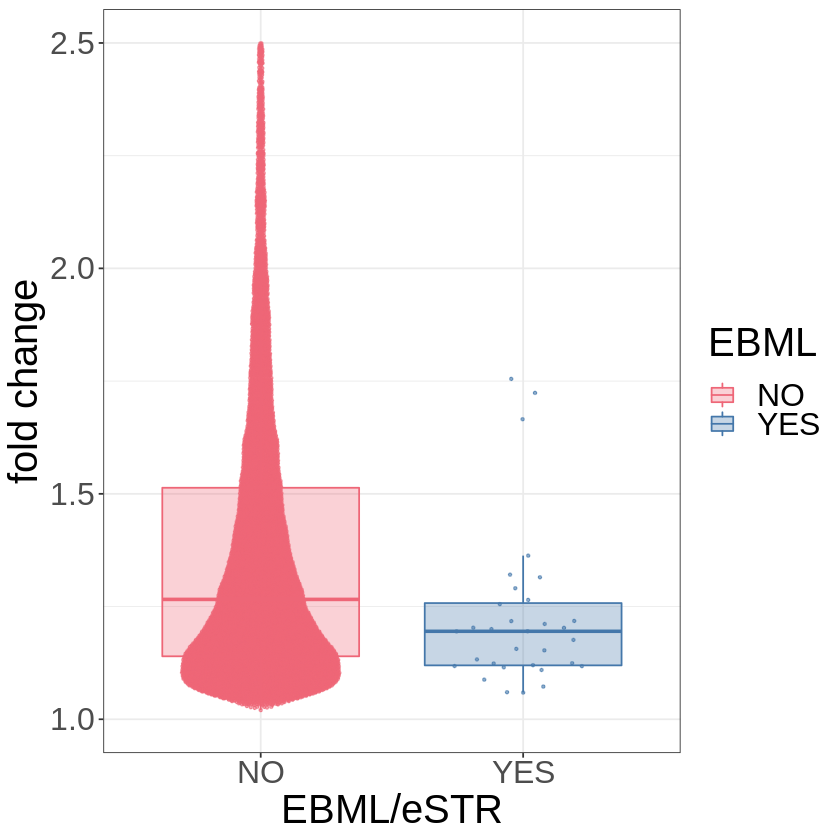

In [4]:
ks.test(sig[which(sig$EBML == "NO"),c("abs")],sig[which(sig$EBML == "YES"),c("abs")])
t<-ggplot(as.data.frame(sig),aes(x=EBML, y=abs, fill=EBML, color=EBML))
t <- t + geom_quasirandom(data = sig,alpha = .6, width=.3,show.legend = FALSE,size=.6)
t <- t + geom_boxplot(data=sig,outlier.shape = NA,alpha = .3)
t <- t + theme_bw()
t <- t + scale_fill_manual(values=c('#EE6677','#4477AA'))
t <- t + scale_color_manual(values=c('#EE6677','#4477AA'))
t <- t + xlab("EBML/eSTR")
t <- t + ylab("fold change")
t <- t + scale_y_continuous(limits = c(1,2.5))
t <- t + theme(text = element_text(size = 24))
plot(t)

# figure 3b
Comparison of fold change for genes associated with eSTRs vs all other genes.


	Two-sample Kolmogorov-Smirnov test

data:  sig[which(sig$eSTR == "NO"), c("abs")] and sig[which(sig$eSTR == "YES"), c("abs")]
D = 0.19949, p-value = 1.559e-13
alternative hypothesis: two-sided


Warning message:
“Removed 641 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 641 rows containing missing values (position_quasirandom).”


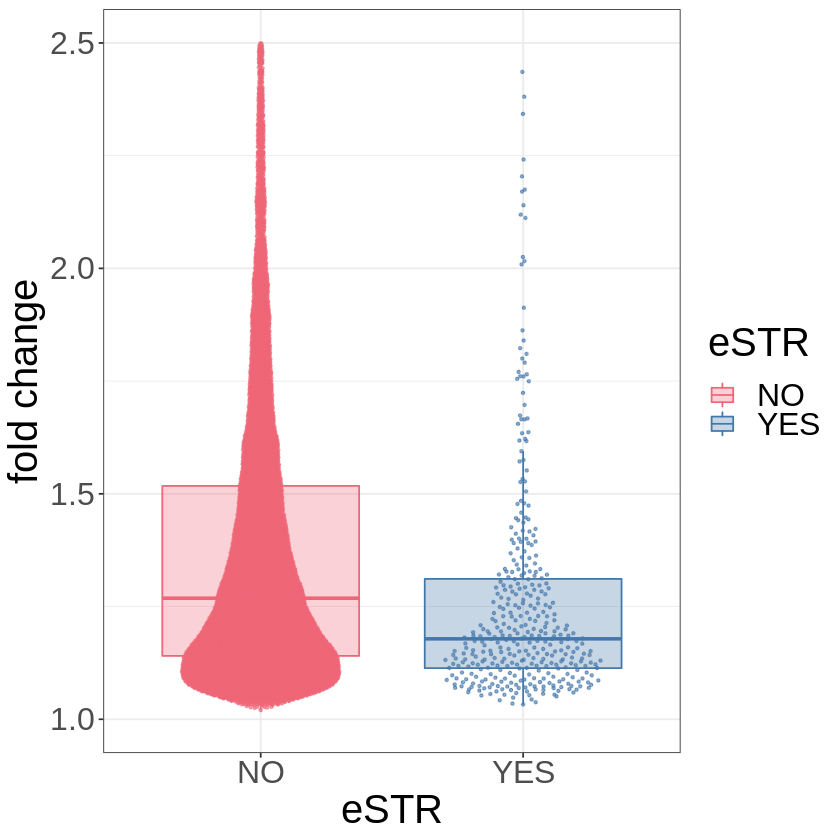

In [5]:
ks.test(sig[which(sig$eSTR == "NO"),c("abs")],sig[which(sig$eSTR == "YES"),c("abs")])
t<-ggplot(as.data.frame(sig),aes(x=eSTR, y=abs, fill=eSTR, color=eSTR))
t <- t + geom_quasirandom(data = sig,alpha = .6, width=.3,show.legend = FALSE,size=.6)
t <- t + geom_boxplot(data=sig,outlier.shape = NA,alpha = .3)
t <- t + theme_bw()
t <- t + scale_fill_manual(values=c('#EE6677','#4477AA'))
t <- t + scale_color_manual(values=c('#EE6677','#4477AA'))
t <- t + xlab("eSTR")
t <- t + ylab("fold change")
t <- t + scale_y_continuous(limits = c(1,2.5))
t <- t + theme(text = element_text(size = 24))
plot(t)

# figure 3c
PCA plot of samples using genes with significant fold change.

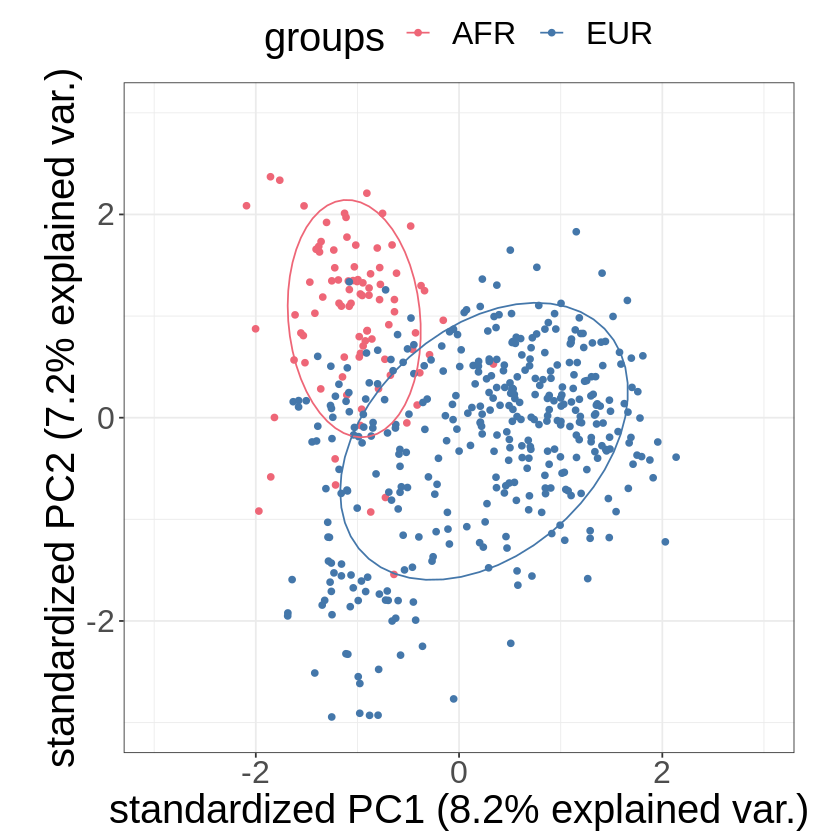

In [6]:
d.deseqSig <- d.deseq[rownames(sig),]
vsd <- getVarianceStabilizedData(d.deseqSig)
pr <- prcomp(t(vsd))
g <- ggbiplot(pr,groups = grp,ellipse = T,var.axes = FALSE)
g <- g + scale_x_continuous(limits=c(-3,3.0))
g <- g + scale_y_continuous(limits=c(-3,3.0))
g <- g + scale_color_manual(values=c('#ee6677','#4477aa'))
g <- g + theme_bw()
g <- g + theme(legend.position = "top")
g <- g + theme(text = element_text(size = 24))
plot(g)

# figure 3d
PCA loadings for all differentially expressed genes

In [7]:
loadings <- ggloading(pr,groups = grp)
loadings$EBML <- "NO"
loadings[which(loadings$varname %in% EBML$ensembl_id),c("EBML")] <- "YES"
loadings$length <- sqrt( loadings$xvar*loadings$xvar + loadings$yvar*loadings$yvar )

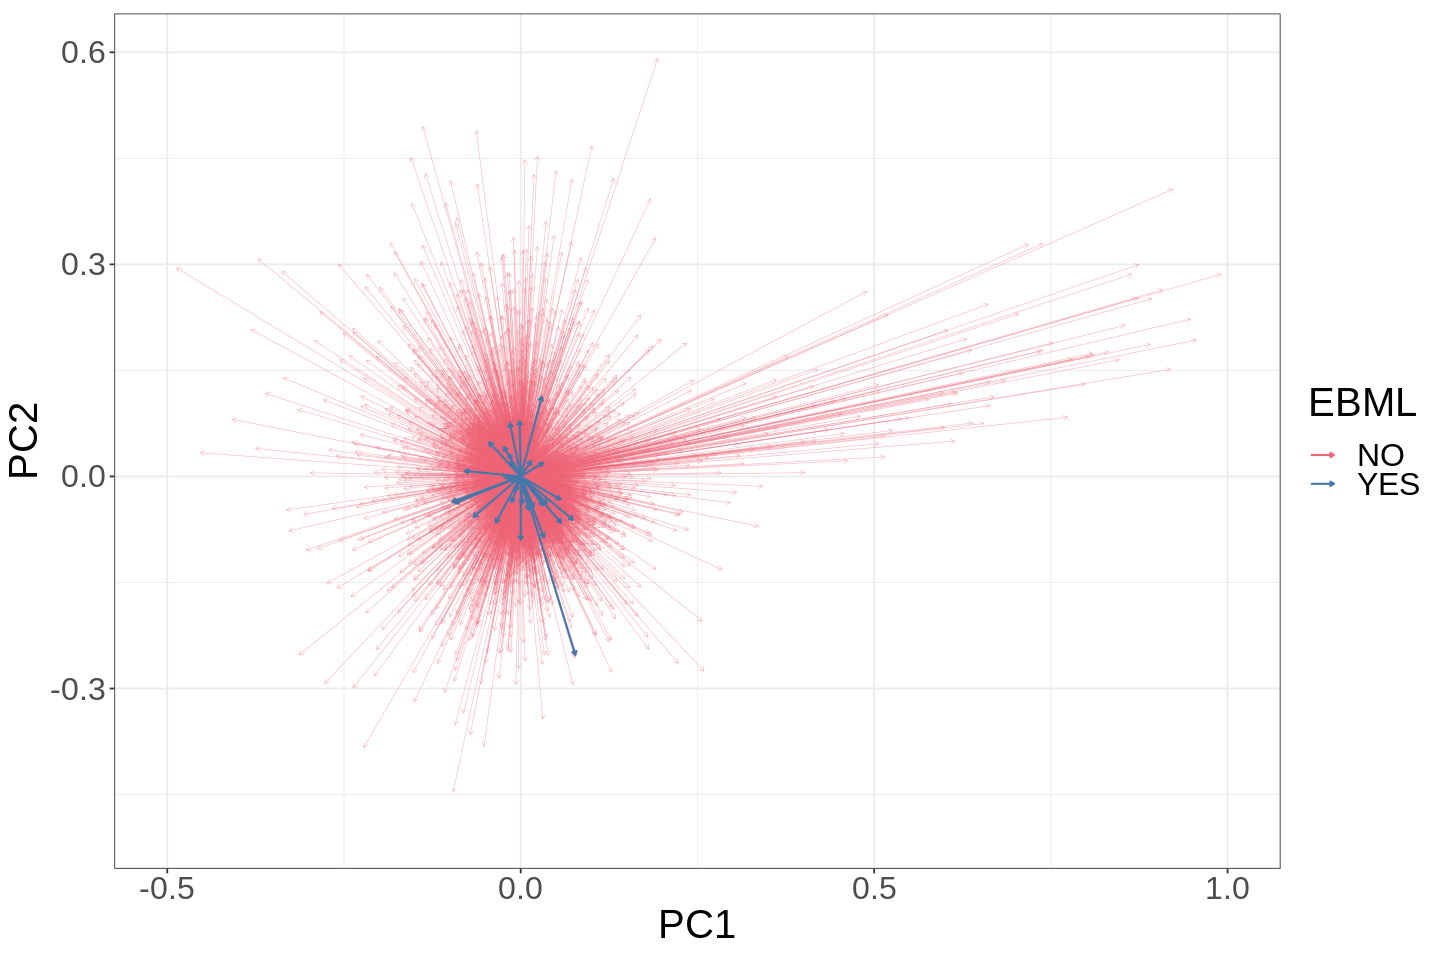

In [8]:
options(repr.plot.width=12, repr.plot.height=8)
g <- ggplot(data = loadings, aes(x = xvar, y = yvar)) + xlab("PC1") + ylab("PC2") + coord_equal()
g <- g + geom_segment(data = loadings[-which(loadings$varname %in% EBML$ensembl_id),], aes(x = 0, y = 0, xend = xvar, yend = yvar, color=EBML), size = .2, alpha = .4, arrow = arrow(length = unit(1/4, 'picas')))
g <- g + geom_segment(data = loadings[which(loadings$varname %in% EBML$ensembl_id),], aes(x = 0, y = 0, xend = xvar, yend = yvar, color=EBML), size = .6, alpha = 1, arrow = arrow(length = unit(1/4, 'picas')))
g <- g + scale_color_manual(values=c('#ee6677','#4477aa'))
g <- g + scale_x_continuous(limits=c(-.5,1.0))
g <- g + scale_y_continuous(limits=c(-.5,.6))
g <- g + theme_bw()
g <- g + theme(text = element_text(size = 24))
plot(g)

# figure 3e
Just a zoom in on the PCA loadings for genes associated with overlapping EBML/eSTRs. The published version has labels which were tricky to add.

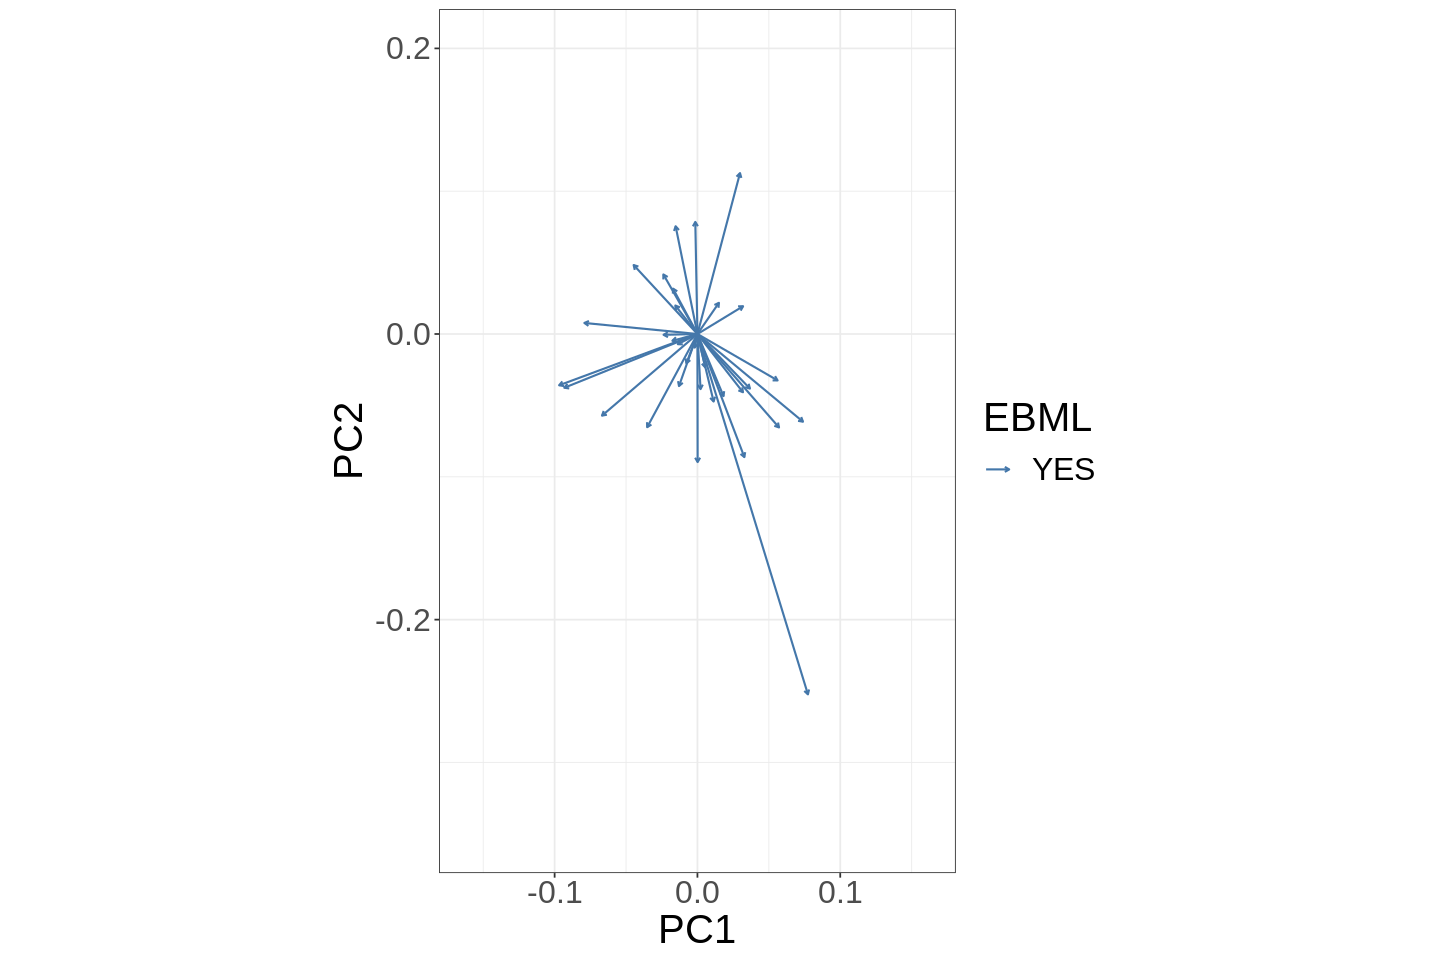

In [9]:
g <- ggplot(data = loadings, aes(x = xvar, y = yvar)) + xlab("PC1") + ylab("PC2") + coord_equal()
g <- g + geom_segment(data = loadings[which(loadings$varname %in% EBML$ensembl_id),], aes(x = 0, y = 0, xend = xvar, yend = yvar, color=EBML), size = .6, alpha = 1, arrow = arrow(length = unit(1/4, 'picas')))
g <- g + scale_color_manual(values=c('#4477aa'))
g <- g + scale_x_continuous(limits=c(-.1645,.1645))
g <- g + scale_y_continuous(limits=c(-.35,.2))
g <- g + theme_bw()
g <- g + theme(text = element_text(size = 24))
plot(g)

# figure 3f
Comparison of the magnitide of PCA loadings for genes assocaited with EBML/eSTRs vs all other genes. 


	Two-sample Kolmogorov-Smirnov test

data:  loadings[which(loadings$EBML == "NO"), c("length")] and loadings[which(loadings$EBML == "YES"), c("length")]
D = 0.15043, p-value = 0.4653
alternative hypothesis: two-sided


Warning message:
“Removed 57 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 57 rows containing missing values (position_quasirandom).”


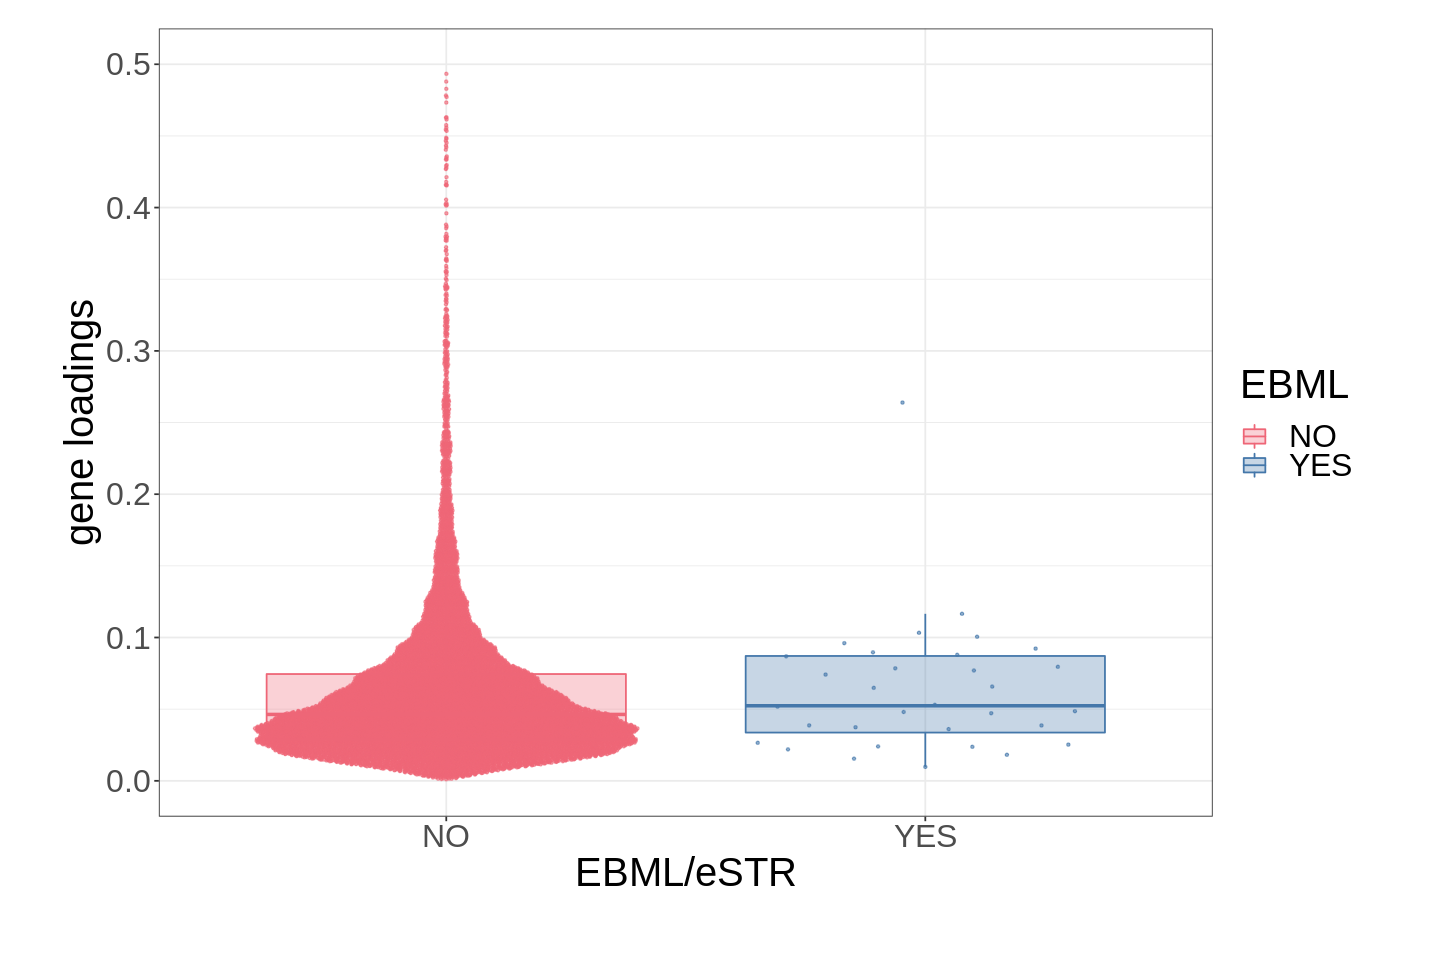

In [10]:
ks.test(loadings[which(loadings$EBML == "NO"),c("length")],loadings[which(loadings$EBML == "YES"),c("length")])
t<-ggplot(loadings, aes(x=EBML, y=length, fill=EBML, color=EBML))
t <- t + geom_quasirandom(data = loadings, alpha = .6, width=.4,show.legend = FALSE,size=.6)
t <- t + geom_boxplot(data=loadings,show.legend = TRUE,outlier.shape = NA,alpha = .3)
t <- t + theme_bw()
t <- t + scale_fill_manual(values=c('#EE6677','#4477AA'))
t <- t + scale_color_manual(values=c('#EE6677','#4477AA'))
t <- t + xlab("EBML/eSTR")
t <- t + ylab("gene loadings")
t <- t + scale_y_continuous(limits = c(0,.5))
t <- t + theme(text = element_text(size = 24))
t <- t + theme ( panel.background = element_rect (fill = "white"), plot.margin = margin (0.602, 1.63, 1.388, 1.37, "cm") )
plot(t)